In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pickle
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
path = '/Data/contents_dict.txt'
with open(path, "rb") as fp:
  contents_load = pickle.load(fp)

In [28]:
n = len(list(contents_load.keys()))
df = pd.DataFrame(columns=['content', 'class'], index=range(0, n))
for i in range(0, n):
  df['content'].iloc[i] = remove_stopwords(contents_load[i][0]).replace('said', '').replace('year', '') #Clean the stopwords
  df['class'].iloc[i] = contents_load[i][1]
df

,content,class
0,Ask Jeeves tips online ad revival Ask Jeeves l...,business
1,UK economy facing 'major risks' The UK manufac...,business
2,US rate rise expected US rates expected rise f...,business
3,US Ahold suppliers face charges US prosecutors...,business
4,Egypt sell state-owned bank The Egyptian gover...,business
...,...,...
2220,Confusion high-definition TV Now critical mass...,tech
2221,'No re-draft' EU patent law A proposed Europea...,tech
2222,Hollywood sue net film pirates The US movie in...,tech
2223,"Lifestyle 'governs mobile choice' Faster, bett...",tech


In [29]:
text_data = np.array(df['content'])
count = CountVectorizer(stop_words='english')
count.fit(text_data)
bag_of_words = count.fit_transform(text_data)
X = bag_of_words.toarray()
X.shape

(2225, 29123)

In [30]:
y = list(df['class'])
def encode(item):
  label_dict = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
  return label_dict[item]
y = list(map(encode, y))
y = np.array(y)
y

array([0, 0, 0, ..., 4, 4, 4])

In [31]:
print(X.shape)
print(y.shape)

(2225, 29123)
(2225,)


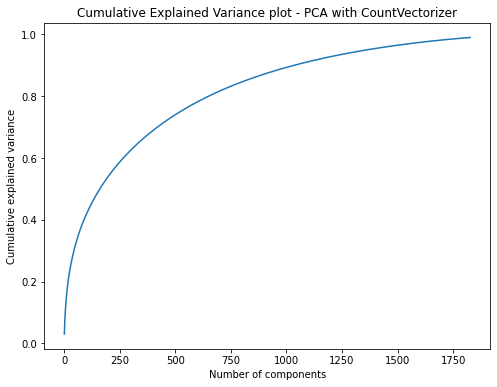

In [32]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(PCA(.99).fit(X).explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Cumulative Explained Variance plot - PCA with CountVectorizer")
plt.savefig("Fig1.pdf", format="pdf")

In [33]:
pca = PCA(.90)
pca.fit(X)
X = pca.transform(X)
pca.n_components_

1036

In [37]:
from sklearn import metrics
list_sil = []
K = range(2,8)
for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(X)
  labels = kmeanModel.predict(X)
  sil = metrics.silhouette_score(X, labels, metric = 'euclidean')
  list_sil.append(sil)

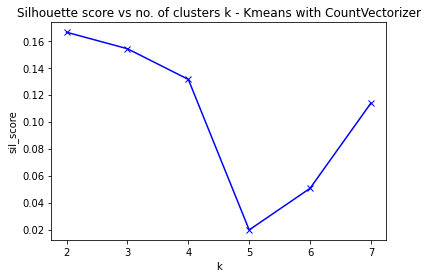

In [38]:
plt.plot(K, list_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('Silhouette score vs no. of clusters k - Kmeans with CountVectorizer')
plt.savefig('Silhouette score vs no. of clusters k - Kmeans with CountVectorizer.pdf', format='pdf')
plt.show()

In [41]:
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(X)
gmmModel = GaussianMixture(n_components = 5)
gmmModel.fit(X)

GaussianMixture(n_components=5)

In [42]:
y_pred_kMean = kmeanModel.predict(X)
y_pred_gmm = gmmModel.predict(X)
from sklearn.metrics import accuracy_score

In [43]:
y_pred_kMean = list(y_pred_kMean)
y_pred_gmm = list(y_pred_gmm)

In [44]:
df_result = df
df_result['class_pred'] = y_pred_kMean #Experiments using wordcloud with results from Kmeans and GMM shows that KMean isolated topics much better

In [45]:
from wordcloud import WordCloud

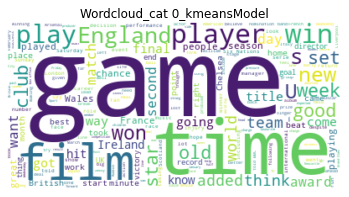

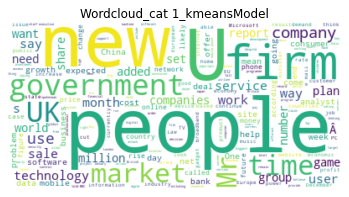

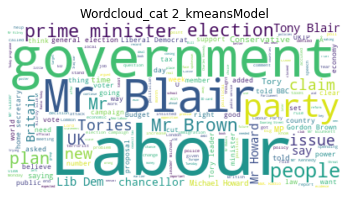

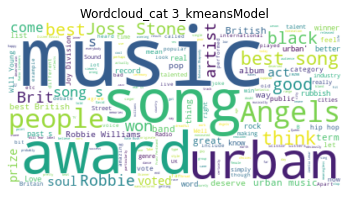

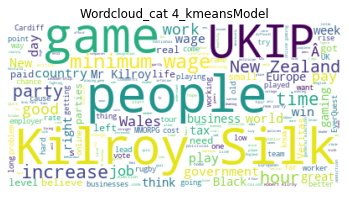

In [46]:
for c in [0, 1, 2, 3, 4]:
  text = ''
  for i in range(0, n):
    if df_result['class_pred'].iloc[i] == c:
      text += ' ' + df_result['content'].iloc[i].strip()
  # Create and generate a word cloud image:
  wordcloud = WordCloud(background_color="white").generate(text)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Wordcloud_cat {c}_kmeansModel")
  plt.savefig(f"Wordcloud_cat {c}_kmeansModel.pdf", format='pdf')
  plt.show()

In [47]:
label_dict_pred = {'business': 1, 'entertainment': 3, 'politics': 2, 'sport': 0, 'tech': 4} #Interpret the topic of each cluster from wordcloud
def convert_class(cl):
  return label_dict_pred[cl]
initial_class_converted = list(map(convert_class, list(df_result['class'])))

In [48]:
df_result['class_converted'] = initial_class_converted
df

,content,class,class_pred,class_converted
0,Ask Jeeves tips online ad revival Ask Jeeves l...,business,1,1
1,UK economy facing 'major risks' The UK manufac...,business,1,1
2,US rate rise expected US rates expected rise f...,business,1,1
3,US Ahold suppliers face charges US prosecutors...,business,0,1
4,Egypt sell state-owned bank The Egyptian gover...,business,1,1
...,...,...,...,...
2220,Confusion high-definition TV Now critical mass...,tech,1,4
2221,'No re-draft' EU patent law A proposed Europea...,tech,1,4
2222,Hollywood sue net film pirates The US movie in...,tech,1,4
2223,"Lifestyle 'governs mobile choice' Faster, bett...",tech,1,4


In [49]:
y_true = np.array(df['class_converted'])
y_pred = np.array(df['class_pred'])
accuracy_score(y_true, y_pred)

0.5186516853932585

**CountVectorizer is not effective --> Let's try TFIDF**

In [50]:
#rebuilt data
n = len(list(contents_load.keys()))
df = pd.DataFrame(columns=['content', 'class'], index=range(0, n))
for i in range(0, n):
  df['content'].iloc[i] = remove_stopwords(contents_load[i][0]).replace('said', '').replace('year', '') #Clean the stopwords
  df['class'].iloc[i] = contents_load[i][1]
df

,content,class
0,Ask Jeeves tips online ad revival Ask Jeeves l...,business
1,UK economy facing 'major risks' The UK manufac...,business
2,US rate rise expected US rates expected rise f...,business
3,US Ahold suppliers face charges US prosecutors...,business
4,Egypt sell state-owned bank The Egyptian gover...,business
...,...,...
2220,Confusion high-definition TV Now critical mass...,tech
2221,'No re-draft' EU patent law A proposed Europea...,tech
2222,Hollywood sue net film pirates The US movie in...,tech
2223,"Lifestyle 'governs mobile choice' Faster, bett...",tech


In [51]:
text_data = np.array(df['content'])
count = TfidfVectorizer()
count.fit(text_data)
bag_of_words = count.fit_transform(text_data)
X = bag_of_words.toarray()
X.shape

(2225, 29396)

In [52]:
y = list(df['class'])
def encode(item):
  label_dict = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
  return label_dict[item]
y = list(map(encode, y))
y = np.array(y)
y

array([0, 0, 0, ..., 4, 4, 4])

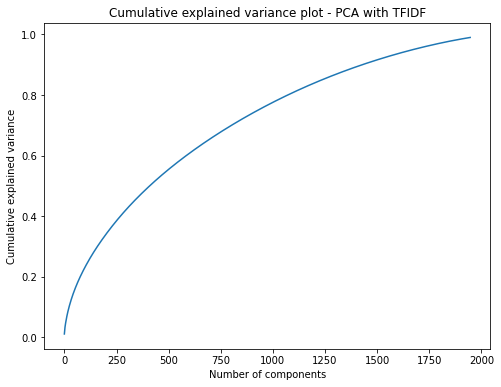

In [53]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(PCA(.99).fit(X).explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Cumulative explained variance plot - PCA with TFIDF")
plt.savefig("Cumulative explained variance plot - PCA with TFIDF.pdf", format="pdf")
plt.show()

In [54]:
pca = PCA(.95)
pca.fit(X)
X = pca.transform(X)
pca.n_components_

1673

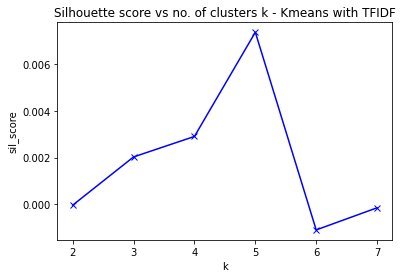

In [59]:
from sklearn import metrics
list_sil = []
K = range(2,8)
for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(X)
  labels = kmeanModel.predict(X)
  sil = metrics.silhouette_score(X, labels, metric = 'euclidean')
  list_sil.append(sil)

plt.plot(K, list_sil, 'bx-')
plt.xlabel('k')
plt.ylabel('sil_score')
plt.title('Silhouette score vs no. of clusters k - Kmeans with TFIDF')
plt.savefig('Silhouette score vs no. of clusters k - Kmeans with TFIDF.pdf', format='pdf')

plt.show()

In [60]:
kmeanModel = KMeans(n_clusters=5) # số cụm
kmeanModel.fit(X)
gmmModel = GaussianMixture(n_components = 5)
gmmModel.fit(X)

GaussianMixture(n_components=5)

In [61]:
y_pred_kMean = kmeanModel.predict(X)
y_pred_gmm = gmmModel.predict(X)

y_pred_kMean = list(y_pred_kMean)
y_pred_gmm = list(y_pred_gmm)

df_result = df
df_result['class_pred'] = y_pred_kMean #Similar to what said before, Kmeans isolated topics much better at this point

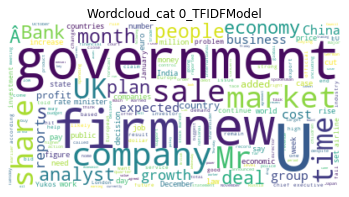

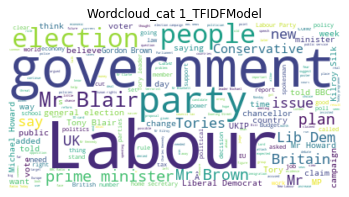

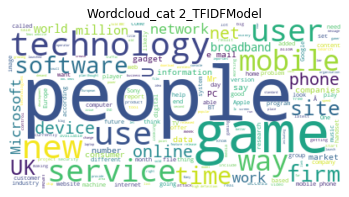

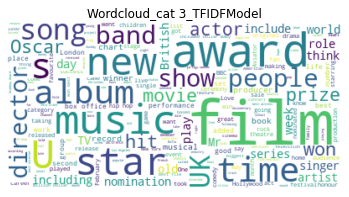

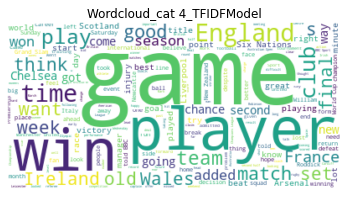

In [63]:
from wordcloud import WordCloud

for c in [0, 1, 2, 3, 4]:
  text = ''
  for i in range(0, n):
    if df_result['class_pred'].iloc[i] == c:
      text += ' ' + df_result['content'].iloc[i].strip()
  # Create and generate a word cloud image:
  wordcloud = WordCloud(background_color="white").generate(text)

  # Display the generated image:
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Wordcloud_cat {c}_TFIDFModel")
  plt.savefig(f"Wordcloud_cat {c}_TFIDFModel.pdf", format='pdf')
  plt.show()

In [64]:
label_dict_pred = {'business': 0, 'entertainment': 3, 'politics': 1, 'sport': 4, 'tech': 2} #Interpret the topic of each cluster from wordcloud
def convert_class(cl):
  return label_dict_pred[cl]
initial_class_converted = list(map(convert_class, list(df_result['class'])))

df_result['class_converted'] = initial_class_converted

from sklearn.metrics import accuracy_score
y_true = np.array(df_result['class_converted'])
y_pred = np.array(df_result['class_pred'])
accuracy_score(y_true, y_pred)

0.8844943820224719

**--> The result of TFIDF is clearly better**